In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor as xgb
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.model_selection import cross_val_score, train_test_split,cross_validate
from sklearn.model_selection import KFold,StratifiedKFold,StratifiedGroupKFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score,classification_report
import optuna
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor








pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)


In [2]:
%%time


class CFG:

    target = "SalePrice"
    train_path = "train.csv"
    submission_path = "test.csv"
    


CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
df=pd.read_csv(CFG.train_path)
ss = pd.read_csv(CFG.submission_path)
df['data'] = 'train'
ss['data'] = 'test'

df = pd.concat([df,ss])
df.loc[df.data=='sub',CFG.target] = np.nan

###     **Analyze Data**

In [4]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0,train
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0,train
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0,train
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0,train
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN,test
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN,test
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN,test
1457,2918,85,RL,62.0,

In [5]:
df.drop(columns="Id", axis=1 , inplace=True)

In [6]:
def analyze_columns(df):
    """
    Veri çerçevesindeki değişkenlerin türlerini ve eksik değerlerini analiz eder.

    Args:
        df (DataFrame): Analiz edilecek veri çerçevesi.

    Returns:
        dict: Değişken türlerini ve eksik değerleri içeren bir sözlük.
    """
    # Kategorik sütunlar
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Numerik sütunlar
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
 

    # Tarih sütunlar
    datetime_cols = df.select_dtypes(include=['datetime']).columns.tolist()

    # Boolean sütunlar
    bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
    
    # Numerik görünen kategorik sütunlar
    numeric_but_categorical = [col for col in numeric_cols if df[col].nunique() < 15]
    
    # Kategorik görünen kardinal sütunlar
    cardinal_categoricals = [col for col in categorical_cols if df[col].nunique() > 30]

    # Eksik değer içeren sütunlar
    nan_cols = [col for col in df.columns if df[col].isna().any()]

    numeric_cols = [col for col in numeric_cols if col not in numeric_but_categorical]

    # Eksik değer içeren sütunların hangi gruplarda olduğu bilgisi
    col_analysis = {
        "categorical_cols": categorical_cols,
        "numeric_cols": numeric_cols,
        "datetime_cols": datetime_cols,
        "bool_cols": bool_cols,
        "numeric_but_categorical": numeric_but_categorical,
        "cardinal_categoricals": cardinal_categoricals
    }
    nan_cols_groups = {col: next(group for group, cols in col_analysis.items() if col in cols) for col in nan_cols}

    # Gözlem sayısı
    Observations = df.shape[0]

    # Değişken sayısı
    Variables = df.shape[1]

    print ({
        "Observations": Observations,
        "Variables": Variables,
        "Categorical Columns": categorical_cols,
        "Numerical Columns": numeric_cols,
        "Datetime Columns": datetime_cols,
        "Boolean Columns": bool_cols,
        "Numerical but Categorical Columns": numeric_but_categorical,
        "Cardinal Categorical Columns": cardinal_categoricals,
        "Columns With NaN Values": nan_cols,
        "Variable Types of Columns with Nan Values": nan_cols_groups
    })

    return categorical_cols, numeric_cols, cardinal_categoricals, numeric_but_categorical, nan_cols

In [7]:
categorical_cols, numeric_cols, cardinal_categoricals, numeric_but_categorical , nan_cols = analyze_columns(df)

{'Observations': 2919, 'Variables': 81, 'Categorical Columns': ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'data'], 'Numerical Columns': ['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'SalePrice'], 'Datet

In [8]:
print("Skewness: %f" % df['SalePrice'].skew())
print("Kurtosis: %f" % df['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


### **Preprocessing Data**

In [9]:
#SalePrice target değişkenimiz olduğu için "test" setinde boş değerler olmalı. O yüzden nan_cols'tan çıkardık

if 'SalePrice' in nan_cols:
    nan_cols.remove('SalePrice')

<Axes: >

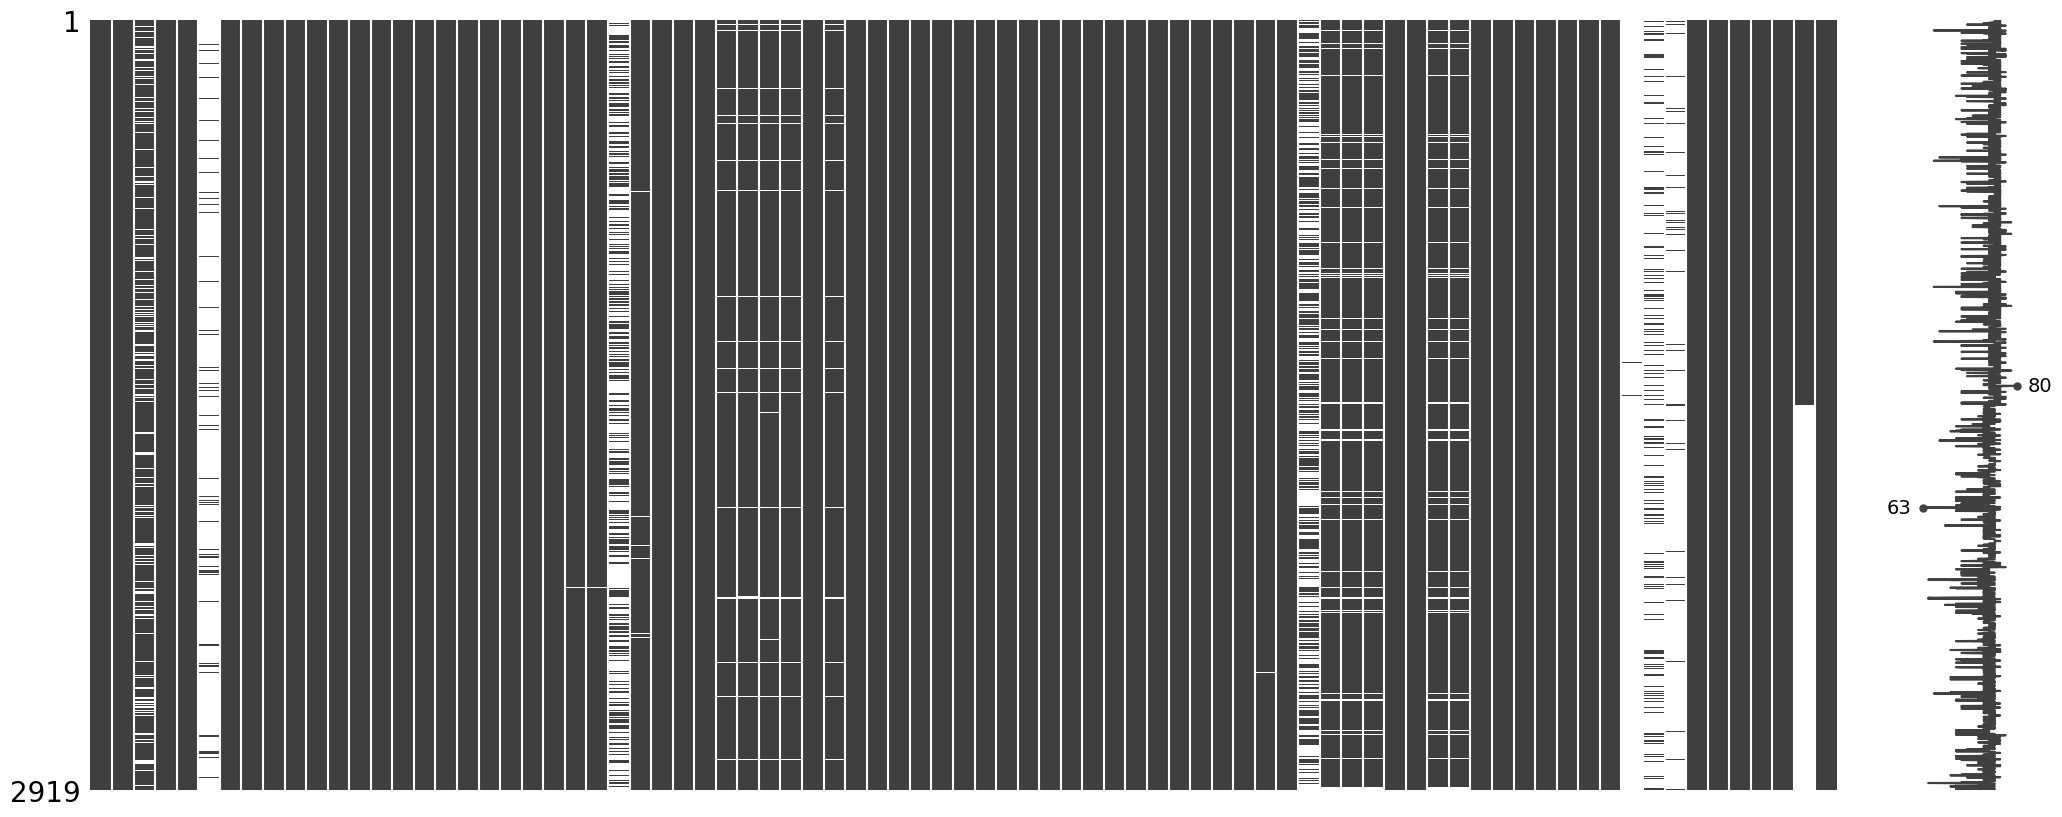

In [10]:
msno.matrix(df)

In [11]:
#Fill Values

df['Functional'] = df['Functional'].fillna('Typ') # Typ: Typical Functionality
df['Electrical'] = df['Electrical'].fillna("SBrkr") # SBrkr: Standard Circuit Breakers & Romex
df['KitchenQual'] = df['KitchenQual'].fillna("TA") # TA: Typical/Average
df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df["PoolQC"] = df["PoolQC"].fillna("None") # note "None" is a string (NA: No Pool)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df[col] = df[col].fillna('None')

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)

df["BsmtFullBath"]=df['BsmtFullBath'].fillna(df['BsmtFullBath'].mode()[0])
df["BsmtHalfBath"]=df['BsmtHalfBath'].fillna(df['BsmtHalfBath'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0]) 
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])

if CFG.target in numeric_cols:
    numeric_cols.remove(CFG.target)

df[numeric_cols] = df[numeric_cols].apply(lambda x: x.fillna(x.mean())) # Fill numerical features with mean

df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

In [12]:
df.isna().sum().sum()

1459

<Axes: >

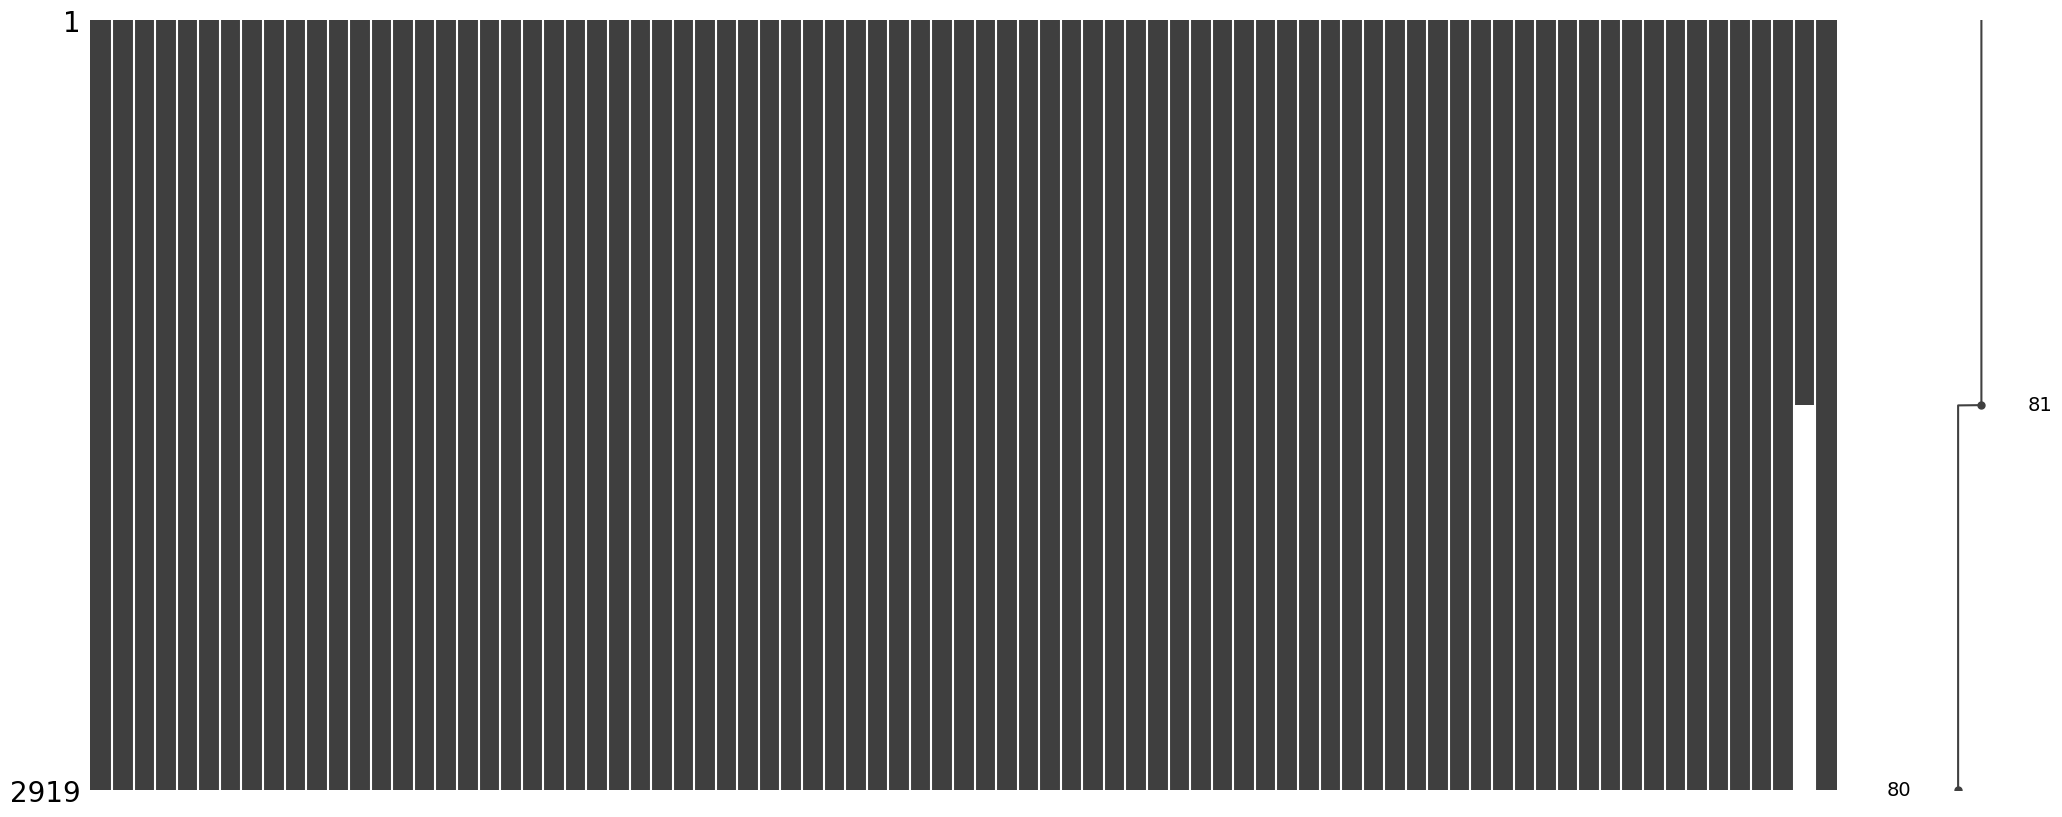

In [13]:
msno.matrix(df)

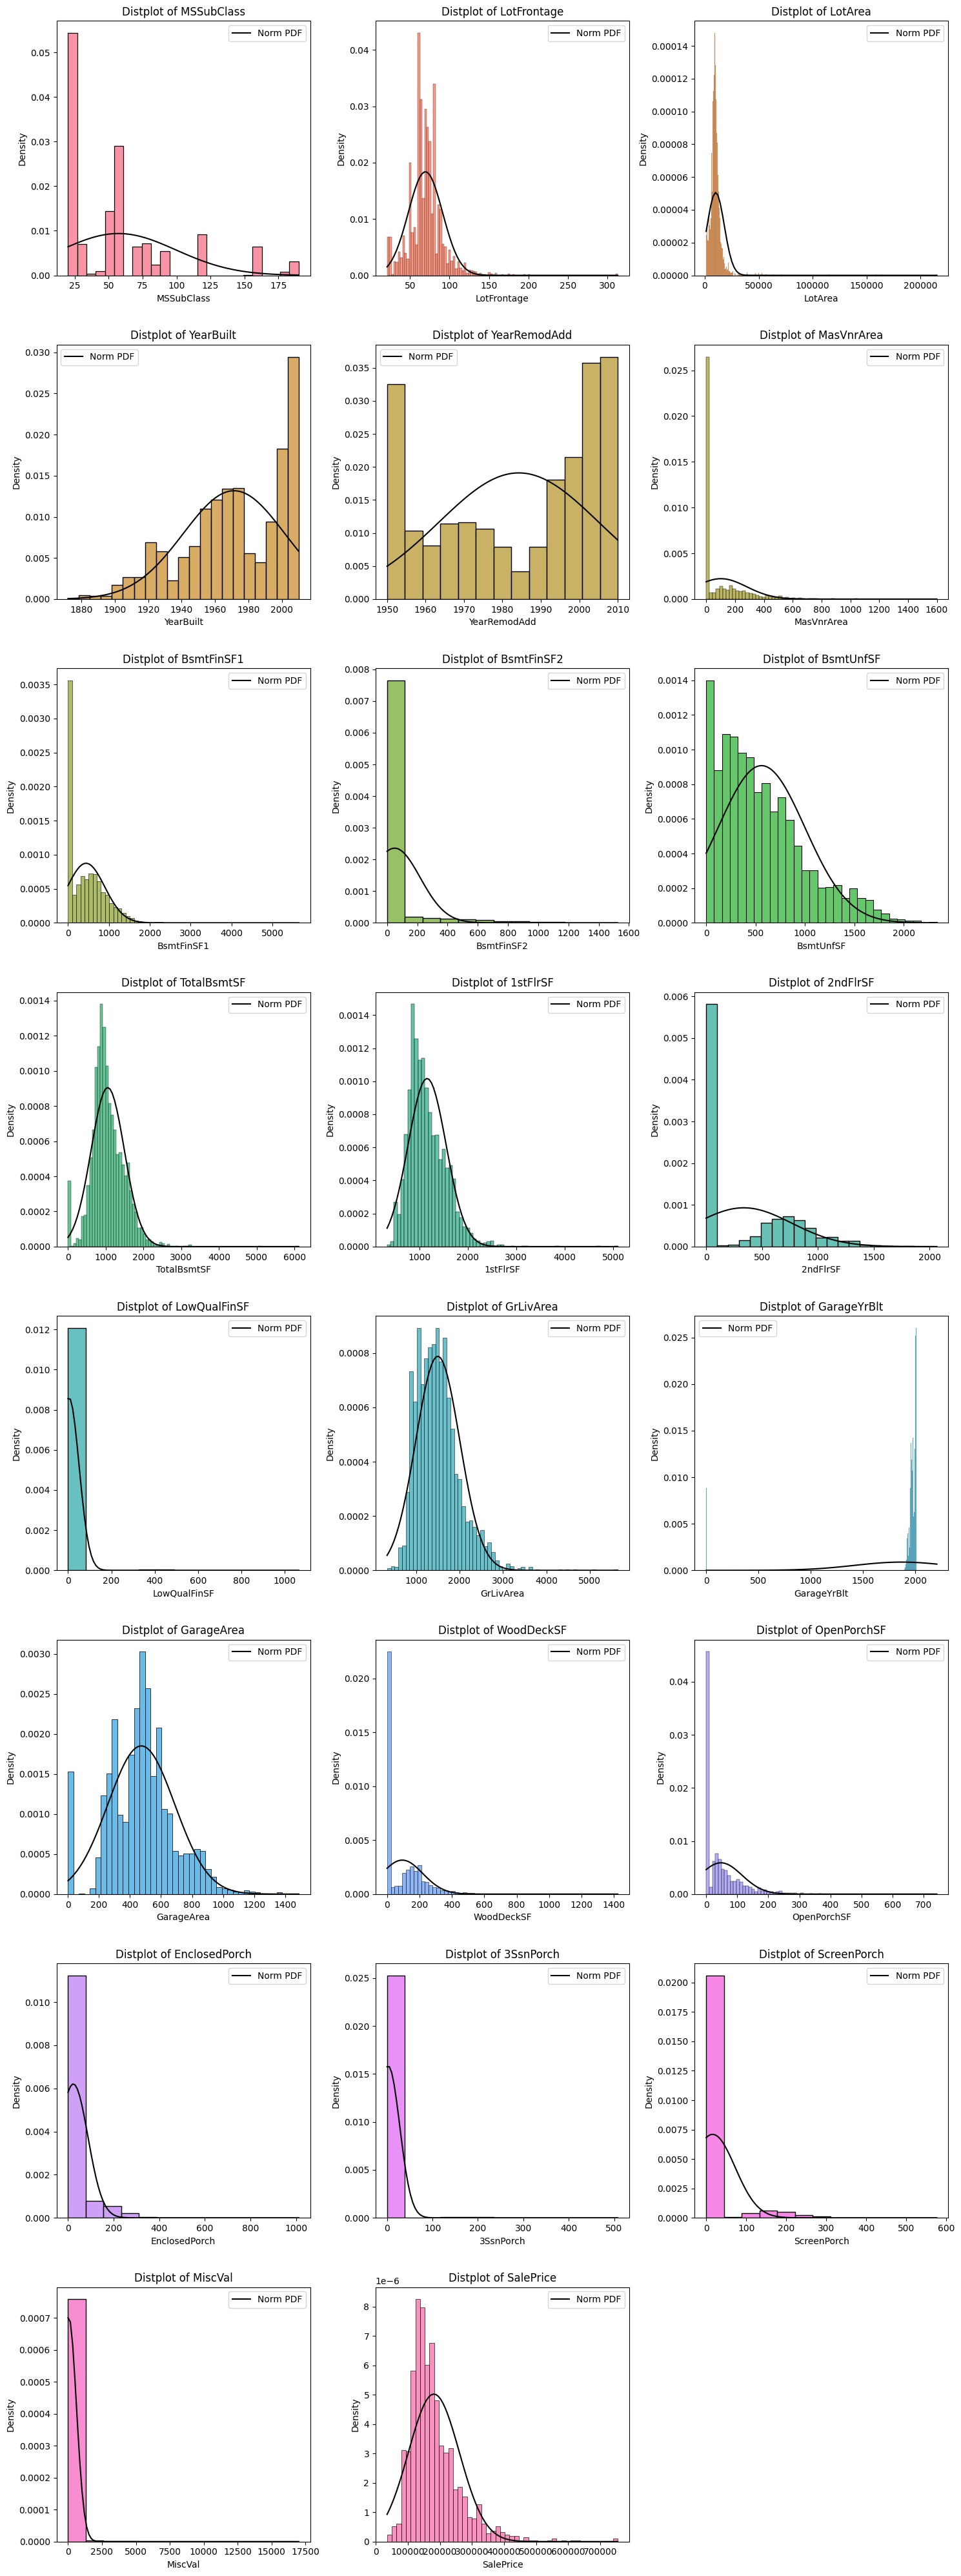

In [14]:
def plot_distplots(df):
    """
    Verilen veri çerçevesindeki her bir sütun için distplotları çizer.

    Argümanlar:
    df (pandas.DataFrame): Distplotları çizilecek veri çerçevesi.
    """
    # Tüm sayısal sütunları alıyoruz
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_but_categorical = [col for col in numeric_cols if df[col].nunique() < 15]
    numeric_cols=[col for col in numeric_cols if col not in numeric_but_categorical]
    
    # Her bir sütun için distplot çizimi
    num_cols = 3  # Her satırda kaç grafik olacağını belirleyin
    num_rows = int(np.ceil(len(numeric_cols) / num_cols))
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    colors = sns.color_palette('husl', len(numeric_cols))
    
    for i, col in enumerate(numeric_cols):
        row = i // num_cols
        col_pos = i % num_cols
        ax = axes[row, col_pos]
        
        sns.histplot(df[col], kde=False, color=colors[i], ax=ax, stat='density')
        
        # Norm eğrisini çizelim
        mean = df[col].mean()
        std = df[col].std()
        x = np.linspace(df[col].min(), df[col].max(), 100)
        norm_pdf = stats.norm.pdf(x, mean, std)
        
        # Norm eğrisini histogram yoğunluklarıyla aynı ölçekte çizelim
        ax.plot(x, norm_pdf, color='black', label='Norm PDF')
        
        ax.set_title(f'Distplot of {col}')
        ax.legend()
    
    # Eğer boş subplotlar kaldıysa, onları gizleyelim
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flatten()[j])
    
    plt.tight_layout(h_pad=3)  # h_pad parametresi ile dikey boşluğu arttırın
    plt.show()

plot_distplots(df)

In [15]:
def analyze_target_feature(df, target):
    """
    Hedef değişkenle ilişkili olarak her bir kategorik ve sayısal değişkeni analiz eder.
    
    Argümanlar:
    df (pandas.DataFrame): Analiz yapılacak veri çerçevesi.
    target (str): Hedef değişkenin adı.
    """
    # Kategorik değişkenlerin hedef değişkene göre ortalamasını hesapla
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_cols:
        print(f"\nKategorik değişken: {col}")
        try:
            # Sadece sayısal değerlere sahip satırları seç
            group_means = df.groupby(col)[target].mean()
            print(group_means)
        except TypeError:
            print(f"{col} sütununda bazı değerler sayısal değil, ortalama hesaplanamadı.")
    
    # Hedef değişkene göre sayısal değişkenlerin ortalamasını hesapla
    numeric_cols = df.select_dtypes(include=['number']).columns
    for col in numeric_cols:
        print(f"\nSayısal değişken: {col}")
        print(df.groupby(target)[col].mean())

In [16]:
analyze_target_feature(df,CFG.target)


Kategorik değişken: MSZoning
MSZoning
C (all)     74528.000000
FV         214014.061538
RH         131558.375000
RL         191004.994787
RM         126316.830275
Name: SalePrice, dtype: float64

Kategorik değişken: Street
Street
Grvl    130190.500000
Pave    181130.538514
Name: SalePrice, dtype: float64

Kategorik değişken: Alley
Alley
Grvl    181294.518675
Pave    168000.585366
Name: SalePrice, dtype: float64

Kategorik değişken: LotShape
LotShape
IR1    206101.665289
IR2    239833.365854
IR3    216036.500000
Reg    164754.818378
Name: SalePrice, dtype: float64

Kategorik değişken: LandContour
LandContour
Bnk    143104.079365
HLS    231533.940000
Low    203661.111111
Lvl    180183.746758
Name: SalePrice, dtype: float64

Kategorik değişken: Utilities
Utilities
AllPub    180950.95682
NoSeWa    137500.00000
Name: SalePrice, dtype: float64

Kategorik değişken: LotConfig
LotConfig
Corner     181623.425856
CulDSac    223854.617021
FR2        177934.574468
FR3        208475.000000
Inside  

In [17]:
def detect_outliers_all_columns(df, threshold=1.5):
    """
    Verilen DataFrame üzerindeki tüm numerik sütunlardaki outlier'ları tespit eden fonksiyon.
    
    Parametreler:
    df (DataFrame): Outlier'ları tespit etmek istediğiniz veri çerçevesi.
    threshold (float): IQR eşik değeri. Varsayılan olarak 1.5 kullanılır.
    
    Döndürülenler:
    dict: Sütun adları ve outlier sayıları dictionary'si.
    """
    outlier_dict = {}
    
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.01)
        Q3 = df[column].quantile(0.99)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        outlier_indices = df[(df[column] < lower_bound) | (df[column] > upper_bound)].index
        num_outliers = len(outlier_indices)
        
        outlier_dict[column] = num_outliers
    
    return outlier_dict

In [18]:
detect_outliers_all_columns(df)

{'MSSubClass': 0,
 'LotFrontage': 2,
 'LotArea': 4,
 'OverallQual': 0,
 'OverallCond': 0,
 'YearBuilt': 0,
 'YearRemodAdd': 0,
 'MasVnrArea': 0,
 'BsmtFinSF1': 1,
 'BsmtFinSF2': 0,
 'BsmtUnfSF': 0,
 'TotalBsmtSF': 1,
 '1stFlrSF': 1,
 '2ndFlrSF': 0,
 'LowQualFinSF': 18,
 'GrLivArea': 0,
 'BsmtFullBath': 0,
 'BsmtHalfBath': 0,
 'FullBath': 0,
 'HalfBath': 0,
 'BedroomAbvGr': 0,
 'KitchenAbvGr': 0,
 'TotRmsAbvGrd': 0,
 'Fireplaces': 0,
 'GarageYrBlt': 0,
 'GarageCars': 0,
 'GarageArea': 0,
 'WoodDeckSF': 1,
 'OpenPorchSF': 1,
 'EnclosedPorch': 1,
 '3SsnPorch': 2,
 'ScreenPorch': 0,
 'PoolArea': 13,
 'MiscVal': 12,
 'MoSold': 0,
 'YrSold': 0,
 'SalePrice': 0}

In [19]:
def handle_outliers(df, method='mask', lower_quantile=0.01, upper_quantile=0.99, threshold=1.5, cap_value=None):
    """
    Aykırı değerleri işler ve maskelenmiş veya sınırlı yöntemleri kullanır.
    
    Args:
        df (DataFrame): Veri çerçevesi.
        method (str): Aykırı değer işleme yöntemi ('remove', 'fill_mean', 'fill_median', 'mask', 'cap', 'leave_as_is').
        lower_quantile (float): Alt quantile değeri. Varsayılan değer 0.25.
        upper_quantile (float): Üst quantile değeri. Varsayılan değer 0.75.
        threshold (float): IQR çarpanı. Varsayılan değer 1.5.
        cap_value (float or None): Sınırlı yöntemde kullanılacak sabit değer. Varsayılan olarak None (kullanılmayacak).
    
    Returns:
        DataFrame: Aykırı değerler işlenmiş veri çerçevesi.
    """
    numeric_columns = df.select_dtypes(include=['number']).columns

    for col in numeric_columns:
        Q1 = df[col].quantile(lower_quantile)
        Q3 = df[col].quantile(upper_quantile)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - (threshold * IQR)
        upper_bound = Q3 + (threshold * IQR)
        
        print(f"{col} - Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

        if method == 'remove':
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        elif method == 'fill_mean':
            mean_value = df[col].mean()
            df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), mean_value, df[col])
        elif method == 'fill_median':
            median_value = df[col].median()
            df[col] = np.where((df[col] < lower_bound) | (df[col] > upper_bound), median_value, df[col])
        elif method == 'mask':
            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
        elif method == 'cap':
            if cap_value is None:
                raise ValueError("Sınırlı yöntem için bir sabit değer belirtmelisiniz (cap_value).")
            df[col] = np.where(df[col] < lower_bound, cap_value, df[col])
            df[col] = np.where(df[col] > upper_bound, cap_value, df[col])
        elif method == 'leave_as_is':
            continue
        else:
            raise ValueError("Geçersiz aykırı değer işleme yöntemi seçildi.")

    return df


In [20]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000
mean,57.137718,69.542994,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,441.423235,49.582248,560.772104,1051.777587,1159.581706,336.483727,4.694416,1500.759849,0.429599,0.061322,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1870.364166,1.766016,472.712573,93.709832,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890
std,42.517628,21.703256,7886.996359,1.409947,1.113131,30.291442,20.894344,178.626089,455.532750,169.176615,439.468337,440.690726,392.362079,428.701456,46.396825,506.051045,0.524676,0.245608,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,449.686321,0.762196,215.535686,126.526589,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000
50%,50.000000,70.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,369.000000,0.000000,467.000000,990.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,163.500000,733.000000,0.000000,805.000000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1526.000000,2336.000000,6110.000000,5095.000000,2065.000000,1064.000000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [21]:
handle_outliers(df)

MSSubClass - Lower Bound: -235.0, Upper Bound: 445.0
LotFrontage - Lower Bound: -146.4600000000005, Upper Bound: 300.1000000000008
LotArea - Lower Bound: -45357.96000000011, Upper Bound: 80076.60000000018
OverallQual - Lower Bound: -7.5, Upper Bound: 20.5
OverallCond - Lower Bound: -6.0, Upper Bound: 18.0
YearBuilt - Lower Bound: 1738.0, Upper Bound: 2170.0
YearRemodAdd - Lower Bound: 1861.5, Upper Bound: 2097.5
MasVnrArea - Lower Bound: -1155.6900000000007, Upper Bound: 1926.1500000000012
BsmtFinSF1 - Lower Bound: -2452.920000000001, Upper Bound: 4088.2000000000016
BsmtFinSF2 - Lower Bound: -1311.9600000000005, Upper Bound: 2186.600000000001
BsmtUnfSF - Lower Bound: -2664.6900000000005, Upper Bound: 4441.1500000000015
TotalBsmtSF - Lower Bound: -3297.3000000000025, Upper Bound: 5495.500000000004
1stFlrSF - Lower Bound: -2132.0300000000025, Upper Bound: 4940.050000000005
2ndFlrSF - Lower Bound: -2100.3000000000025, Upper Bound: 3500.500000000004
LowQualFinSF - Lower Bound: -230.7600000

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,data
0,60.0,RL,65.0,8450.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2003.0,2003.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856.0,854.0,0.0,1710.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,8.0,Typ,0.0,Gd,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0.0,61.0,0.0,0.0,0.0,0.0,None,MnPrv,Shed,0.0,2.0,2008.0,WD,Normal,208500.0,train
1,20.0,RL,80.0,9600.0,Pave,Grvl,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6.0,8.0,1976.0,1976.0,Gable,CompShg,MetalSd,MetalSd,BrkFace,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262.0,0.0,0.0,1262.0,0.0,1.0,2.0,0.0,3.0,1.0,TA,6.0,Typ,1.0,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298.0,0.0,0.0,0.0,0.0,0.0,None,MnPrv,Shed,0.0,5.0,2007.0,WD,Normal,181500.0,train
2,60.0,RL,68.0,11250.0,Pave,Grvl,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7.0,5.0,2001.0,2002.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920.0,866.0,0.0,1786.0,1.0,0.0,2.0,1.0,3.0,1.0,Gd,6.0,Typ,1.0,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0.0,42.0,0.0,0.0,0.0,0.0,None,MnPrv,Shed,0.0,9.0,2008.0,WD,Normal,223500.0,train
3,70.0,RL,60.0,9550.0,Pave,Grvl,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7.0,5.0,1915.0,1970.0,Gable,CompShg,Wd Sdng,Wd Shng,BrkFace,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961.0,756.0,0.0,1717.0,1.0,0.0,1.0,0.0,3.0,1.0,Gd,7.0,Typ,1.0,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0.0,35.0,272.0,0.0,0.0,0.0,None,MnPrv,Shed,0.0,2.0,2006.0,WD,Abnorml,140000.0,train
4,60.0,RL,84.0,14260.0,Pave,Grvl,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8.0,5.0,2000.0,2000.0,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145.0,1053.0,0.0,2198.0,1.0,0.0,2.0,1.0,4.0,1.0,Gd,9.0,Typ,1.0,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192.0,84.0,0.0,0.0,0.0,0.0,None,MnPrv,Shed,0.0,12.0,2008.0,WD,Normal,250000.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160.0,RM,21.0,1936.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4.0,7.0,1970.0,1970.0,Gable,CompShg,CemntBd,CmentBd,BrkFace,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,TA,5.0,Typ,0.0,Gd,None,0.0,None,0.0,0.0,None,None,Y,0.0,0.0,0.0,0.0,0.0,0.0,None,MnPrv,Shed,0.0,6.0,2006.0,WD,Normal,NaN,test
1455,160.0,RM,21.0,1894.0,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4.0,5.0,1970.0,1970.0,Gable,CompShg,CemntBd,CmentBd,BrkFace,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546.0,546.0,0.0,1092.0,0.0,0.0,1.0,1.0,3.0,1.0,TA,6.0,Typ,0.0,Gd,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0.0,24.0,0.0,0.0,0.0,0.0,None,MnPrv,Shed,0.0,4.0,2006.0,WD,Abnorml,NaN

In [22]:
df.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.0,2919.000000,2919.000000,2919.000000,1460.000000
mean,57.137718,69.534156,10053.777801,6.089072,5.564577,1971.312778,1984.264474,102.201312,440.890244,49.582248,560.772104,1051.567070,1159.528623,336.483727,3.892360,1500.759849,0.429599,0.061322,1.568003,0.380267,2.860226,1.044536,6.451524,0.597122,1870.364166,1.766016,472.712573,93.650925,47.476242,22.977732,2.535457,16.062350,0.0,32.381295,6.213087,2007.792737,180921.195890
std,42.517628,21.606484,5910.220057,1.409947,1.113131,30.291442,20.894344,178.626089,450.323842,169.176615,439.468337,438.414487,391.839601,428.701456,36.005205,506.051045,0.524676,0.245608,0.552969,0.502872,0.822693,0.214462,1.569379,0.646129,449.686321,0.762196,215.535686,125.945726,67.469164,62.699178,24.050125,56.184365,0.0,216.165151,2.714762,1.314964,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,0.000000,0.000000,220.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,4.000000,2007.000000,129975.000000
50%,50.000000,70.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,369.000000,0.000000,467.000000,990.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.0,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,163.500000,733.000000,0.000000,805.000000,1302.000000,1387.500000,704.000000,0.000000,1743.500000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.0,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,300.100000,80076.600000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,4088.200000,1526.000000,2336.000000,5495.500000,4940.050000,2065.000000,384.600000,5642.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1252.050000,711.150000,660.000000,360.000000,576.000000,0.0,2455.000000,12.000000,2010.000000,755000.000000


### **Feature Engineering**

In [23]:
# Creating new features by adding related columns
df['YearBuiltAndRemod'] = df['YearBuilt'] + df['YearRemodAdd']
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']

df['TotalSquareFootage'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] +
                            df['1stFlrSF'] + df['2ndFlrSF'])

df['TotalBathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                        df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                      df['EnclosedPorch'] + df['ScreenPorch'] +
                      df['WoodDeckSF'])


# Simplifying features. For some numeric columns with skewed distributions, convert them to binary (0 or 1) values.

df['has_pool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['has2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasgarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['hasbsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [24]:
def one_hot_rare_encoding(df, rare_threshold=0.01):
    # Rare encoding
    for col in df.select_dtypes(include='object').columns:
        frequencies = df[col].value_counts(normalize=True)
        rare_categories = frequencies[frequencies < rare_threshold].index
        df[col + '_rare'] = np.where(df[col].isin(rare_categories), 'rare', df[col])

    # One-hot encoding
    ohe = OneHotEncoder(drop='first')
    categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and col.endswith('_rare')]
    encoded_values = ohe.fit_transform(df[categorical_cols])
    encoded_cols = ohe.get_feature_names_out(categorical_cols)
    encoded_df = pd.DataFrame(encoded_values.toarray(), columns=encoded_cols, index=df.index)

    # Concatenate encoded categorical features, 'data' column, and numeric features
    numeric_cols = df.select_dtypes(include='number').columns.tolist()
    df_encoded = pd.concat([encoded_df, df[['data'] + numeric_cols]], axis=1)

    return df_encoded

In [25]:
# def rare_encoding(df, threshold=0.01):
#     """
#     Apply rare encoding to categorical features in the dataframe.
#     Categories with a frequency less than the threshold will be replaced with 'Other'.
    
#     Args:
#     df (pd.DataFrame): The input dataframe.
#     threshold (float): The frequency threshold for rare encoding.
    
#     Returns:
#     pd.DataFrame: The dataframe with rare encoding applied.
#     """
#     categorical_cols = list(df.select_dtypes(exclude='number').columns)
    
#     if 'data' in categorical_cols:
#         categorical_cols.remove('data')
    
#     for col in categorical_cols:
#         # Calculate the frequency of each category
#         freq = df[col].value_counts(normalize=True)
#         # Identify rare categories
#         rare_categories = freq[freq < threshold].index
#         # Replace rare categories with 'Other'
#         df[col] = df[col].apply(lambda x: 'Other' if x in rare_categories else x)
    
#     return df

In [26]:
# def label_encoding_with_rare(df, threshold=0.01):
#     """
#     Apply rare encoding and label encoding to the dataframe.
    
#     Args:
#     df (pd.DataFrame): The input dataframe.
#     threshold (float): The frequency threshold for rare encoding.
    
#     Returns:
#     pd.DataFrame: The dataframe with rare encoding and label encoding applied.
#     """
#     df = rare_encoding(df, threshold=threshold)

#     le = LabelEncoder()
#     categorical_cols = list(df.select_dtypes(exclude='number').columns)
    
#     if 'data' in categorical_cols:
#         categorical_cols.remove('data')
    
#     for col in categorical_cols:
#         df[col] = le.fit_transform(df[col])

#     return df

In [27]:
df_encoded = one_hot_rare_encoding(df, rare_threshold=0.01)

C:\Users\utku\AppData\Local\Temp\ipykernel_20200\1227961261.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_rare'] = np.where(df[col].isin(rare_categories), 'rare', df[col])
C:\Users\utku\AppData\Local\Temp\ipykernel_20200\1227961261.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col + '_rare'] = np.where(df[col].isin(rare_categories), 'rare', df[col])
C:\Users\utku\AppData\Local\Temp\ipykernel_20200\1227961261.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling

### ML PART 

In [28]:
df_encoded[CFG.target] = np.log1p(df[CFG.target])

In [29]:
df_encoded[CFG.target].max()

13.534474352733596

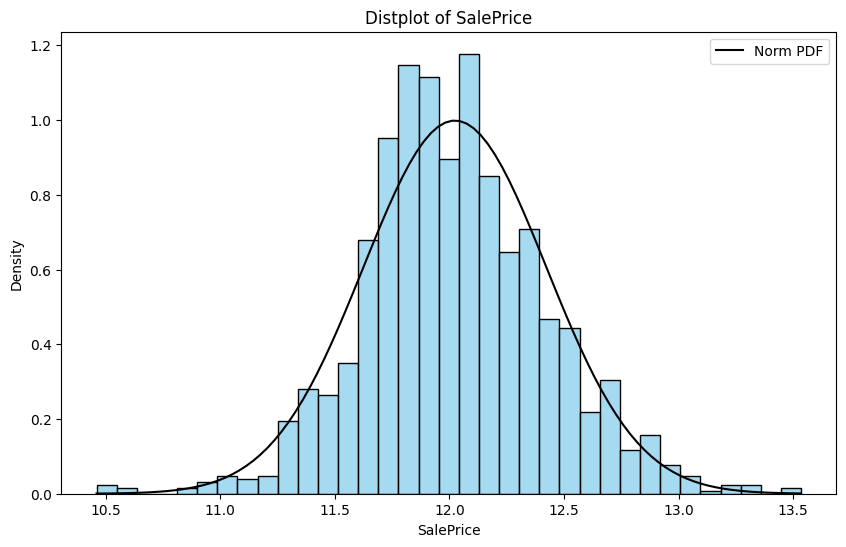

In [30]:
def plot_distplot_target(df, target_col):
    """
    Verilen veri çerçevesindeki belirli bir sütun için distplot çizer.

    Argümanlar:
    df (pandas.DataFrame): Distplot çizilecek veri çerçevesi.
    target_col (str): Distplot çizilecek sütun ismi.
    """
    # Hedef sütunun adını kontrol edin
    if target_col not in df.columns:
        raise ValueError(f"Column '{target_col}' does not exist in the dataframe.")
    
    # Sadece target sütunu için distplot çizimi
    plt.figure(figsize=(10, 6))
    sns.histplot(df[target_col], kde=False, color='skyblue', stat='density')

    # Norm eğrisini çizelim
    mean = df[target_col].mean()
    std = df[target_col].std()
    x = np.linspace(df[target_col].min(), df[target_col].max(), 100)
    norm_pdf = stats.norm.pdf(x, mean, std)
    
    # Norm eğrisini histogram yoğunluklarıyla aynı ölçekte çizelim
    plt.plot(x, norm_pdf, color='black', label='Norm PDF')
    
    plt.title(f'Distplot of {target_col}')
    plt.legend()
    plt.show()

plot_distplot_target(df_encoded,target_col=CFG.target)

In [31]:
# "data" sütununa göre veri setini ayırma
train_df = df_encoded[df_encoded['data'] == 'train']
test_df = df_encoded[df_encoded['data'] == 'test']



In [32]:
y = train_df[CFG.target]
X = train_df.drop(columns=([CFG.target,"data"]), axis=1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [34]:
#y_train_log = np.log1p(y_train)  # np.log1p is equivalent to np.log(1 + x)
#y_test_log = np.log1p(y_test)


In [35]:
categorical_cols_encoded = df_encoded.select_dtypes(include='object').columns.tolist()
print("Categorical Columns in df_encoded:")
print(categorical_cols_encoded)

Categorical Columns in df_encoded:
['data']


RF: 0.139597 (0.024593)

Top 20 features for RF:
1. Feature OverallQual: 0.38851197251806224
2. Feature TotalSF: 0.33447792192364484
3. Feature TotalSquareFootage: 0.0644621581583572
4. Feature YearBuiltAndRemod: 0.02231432282856628
5. Feature OverallCond: 0.010454204126963589
6. Feature LotArea: 0.010377860503461473
7. Feature GarageCars: 0.00971142900080837
8. Feature GrLivArea: 0.009065667168755375
9. Feature YearRemodAdd: 0.009050667348294187
10. Feature GarageArea: 0.008834715567264445
11. Feature YearBuilt: 0.008343175706132598
12. Feature CentralAir_rare_Y: 0.007655007631066215
13. Feature BsmtFinSF1: 0.0064193328789067285
14. Feature TotalBathrooms: 0.005859016309313212
15. Feature TotalPorchSF: 0.005739675202403838
16. Feature GarageYrBlt: 0.00569292106165893
17. Feature 1stFlrSF: 0.005553302519253741
18. Feature LotFrontage: 0.005356532769615868
19. Feature TotalBsmtSF: 0.0051664156764724654
20. Feature BsmtUnfSF: 0.004378486400487139
GBM: 0.125175 (0.026016)

Top 20 features

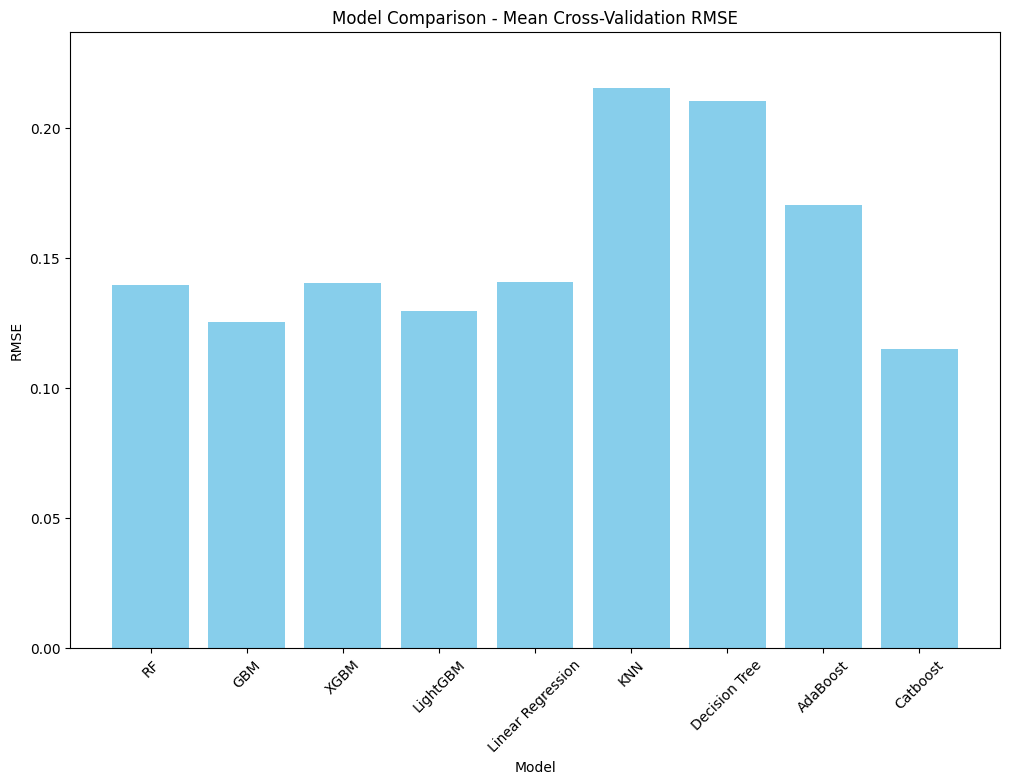

RF Test RMSE: 0.1495
GBM Test RMSE: 0.1352
XGBM Test RMSE: 0.1410
LightGBM Test RMSE: 0.1411
Linear Regression Test RMSE: 0.1329
KNN Test RMSE: 0.2205
Decision Tree Test RMSE: 0.2105
AdaBoost Test RMSE: 0.1715
Catboost Test RMSE: 0.1296


In [36]:

models = [
    ('RF', RandomForestRegressor()),
    ('GBM', GradientBoostingRegressor()),
    ('XGBM', XGBRegressor()),
    ("LightGBM", LGBMRegressor(verbose=-1)),
    ("Linear Regression", LinearRegression()),
    ('KNN', KNeighborsRegressor()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('AdaBoost', AdaBoostRegressor()),
    ("Catboost", CatBoostRegressor(silent=True))
]

results = []
names = []
mean_rmse = []

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="neg_root_mean_squared_error")
    results.append(cv_results)
    names.append(name)
    mean_rmse.append(cv_results.mean())
    msg = "%s: %f (%f)" % (name, -cv_results.mean(), cv_results.std())
    print(msg)
    
    # Fit model to get feature importances (for models that support it)
    if name in ['RF', 'GBM', 'XGBM', 'LightGBM', 'KNN', 'Decision Tree', 'AdaBoost', 'Linear Regression', 'Catboost']:
        model.fit(X_train, y_train)
        # Get feature importances or coefficients
        if hasattr(model, 'feature_importances_'):
            feature_importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            feature_importances = model.coef_
        else:
            feature_importances = None
        
        if feature_importances is not None:
            # Sort feature importances in descending order
            if name in ['GBM', 'XGBM', 'LightGBM']:
                indices = np.argsort(feature_importances)[::-1]
            else:
                indices = np.argsort(-feature_importances)
            
            # Print the top 20 features
            feature_names = X_train.columns
            print(f"\nTop 20 features for {name}:")
            for i in range(min(20, len(feature_importances))):
                print(f"{i+1}. Feature {feature_names[indices[i]]}: {feature_importances[indices[i]]}")

# Plotting the RMSE results
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(names, [-x for x in mean_rmse], color='skyblue')
plt.title('Model Comparison - Mean Cross-Validation RMSE')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylim(0, max([-x for x in mean_rmse]) * 1.1)
plt.show()

# Evaluate the models on the test set
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} Test RMSE: {rmse:.4f}")


Important features for RF (208 features): ['MSZoning_rare_RL', 'MSZoning_rare_RM', 'MSZoning_rare_rare', 'Street_rare_rare', 'Alley_rare_Pave', 'LotShape_rare_IR2', 'LotShape_rare_Reg', 'LotShape_rare_rare', 'LandContour_rare_HLS', 'LandContour_rare_Low', 'LandContour_rare_Lvl', 'LotConfig_rare_CulDSac', 'LotConfig_rare_FR2', 'LotConfig_rare_Inside', 'LotConfig_rare_rare', 'LandSlope_rare_Mod', 'LandSlope_rare_rare', 'Neighborhood_rare_BrkSide', 'Neighborhood_rare_ClearCr', 'Neighborhood_rare_CollgCr', 'Neighborhood_rare_Crawfor', 'Neighborhood_rare_Edwards', 'Neighborhood_rare_Gilbert', 'Neighborhood_rare_IDOTRR', 'Neighborhood_rare_MeadowV', 'Neighborhood_rare_Mitchel', 'Neighborhood_rare_NAmes', 'Neighborhood_rare_NWAmes', 'Neighborhood_rare_NoRidge', 'Neighborhood_rare_NridgHt', 'Neighborhood_rare_OldTown', 'Neighborhood_rare_SWISU', 'Neighborhood_rare_Sawyer', 'Neighborhood_rare_SawyerW', 'Neighborhood_rare_Somerst', 'Neighborhood_rare_StoneBr', 'Neighborhood_rare_Timber', 'Neigh

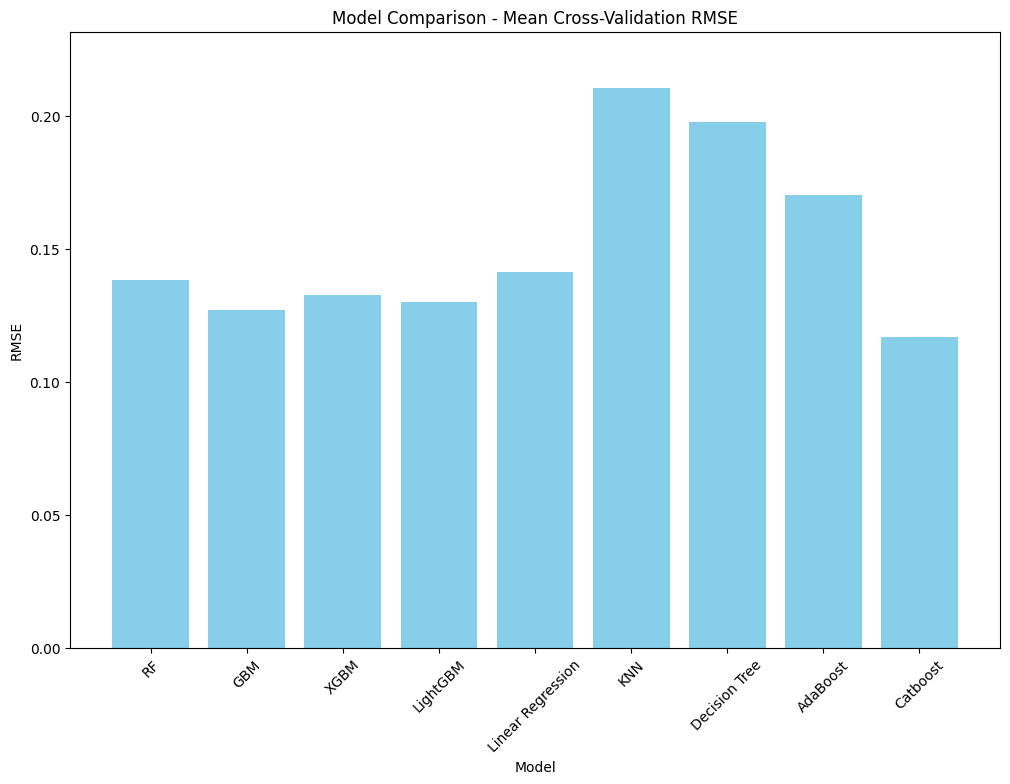

RF Test RMSE: 0.1453
GBM Test RMSE: 0.1352
XGBM Test RMSE: 0.1415
LightGBM Test RMSE: 0.1392
Linear Regression Test RMSE: 0.1348
KNN Test RMSE: 0.2205
Decision Tree Test RMSE: 0.2126
AdaBoost Test RMSE: 0.1759
Catboost Test RMSE: 0.1324


In [41]:
models = [
    ('RF', RandomForestRegressor()),
    ('GBM', GradientBoostingRegressor()),
    ('XGBM', XGBRegressor()),
    ("LightGBM", LGBMRegressor(verbose=-1)),
    ("Linear Regression", LinearRegression()),
    ('KNN', KNeighborsRegressor()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('AdaBoost', AdaBoostRegressor()),
    ("Catboost", CatBoostRegressor(silent=True))
]

results = []
names = []
mean_rmse = []

# Fit the models to get feature importances
for name, model in models:
    model.fit(X_train, y_train)
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        total_features = len(feature_importances)
    elif hasattr(model, 'coef_'):
        feature_importances = model.coef_
        total_features = len(feature_importances)
    else:
        feature_importances = None
        total_features = None
    
    if feature_importances is not None:
        # Find features with importances greater than 0.0000
        important_features = [X.columns[i] for i in range(len(feature_importances)) if feature_importances[i] > 0.0000]
        print(f"\nImportant features for {name} ({total_features} features): {important_features}")

    # Filter X_train and X_test to keep only the important features
    X_train_filtered = X_train[important_features]
    X_test_filtered = X_test[important_features]

    # Evaluate the models again using filtered features
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring="neg_root_mean_squared_error")
    results.append(cv_results)
    names.append(name)
    mean_rmse.append(cv_results.mean())
    msg = "%s: %f (%f)" % (name, -cv_results.mean(), cv_results.std())
    print(msg)
    
    # Fit model and print feature importances if available
    model.fit(X, y)
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importances = model.coef_
    else:
        feature_importances = None
    
    if feature_importances is not None:
        # Sort feature importances in descending order
        indices = np.argsort(-feature_importances)
        # Print the top 20 features
        feature_names = X.columns
        print(f"\nTop 20 features for {name}:")
        for i in range(min(20, len(feature_importances))):
            print(f"{i+1}. Feature {feature_names[indices[i]]}: {feature_importances[indices[i]]}")

    # Print the total number of features used in the model
    print(f"Total number of features used in {name}: {total_features}")

# Plotting the RMSE results
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(names, [-x for x in mean_rmse], color='skyblue')
plt.title('Model Comparison - Mean Cross-Validation RMSE')
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.ylim(0, max([-x for x in mean_rmse]) * 1.1)
plt.show()

# Evaluate the models on the test set using filtered features
for name, model in models:
    model.fit(X_train_filtered, y_train)
    y_pred = model.predict(X_test_filtered)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name} Test RMSE: {rmse:.4f}")

In [42]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 10000),  # Number of boosting iterations
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),  # Learning rate
        'depth': trial.suggest_int('depth', 3, 10),  # Depth of the trees
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),  # L2 regularization
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),  # Random strength
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.001, 1.0, log=True),  # Bagging temperature
        'border_count': trial.suggest_int('border_count', 32, 255),  # Number of partitions for border
    }

    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train_filtered, y_train)
    y_pred = model.predict(X_test_filtered)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# Print best hyperparameters and RMSE
best_params = study.best_params
best_rmse = study.best_value
print(f"Best RMSE: {best_rmse:.4f}")
print("Best hyperparameters:")
for key, value in best_params.items():
    print(f"{key}: {value}")

# Train CatBoostRegressor with the best hyperparameters
best_model = CatBoostRegressor(**best_params, silent=True)
best_model.fit(X, y)

# Evaluate on the test set
y_pred = best_model.predict(X_test_filtered)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Final Test RMSE with best model: {final_rmse:.4f}")

[I 2024-07-09 21:47:59,258] A new study created in memory with name: no-name-2c9adf96-b00b-4791-9a67-e5d25dd33a93
[I 2024-07-09 21:47:59,545] Trial 0 finished with value: 0.1695018075367262 and parameters: {'iterations': 220, 'learning_rate': 0.013310680401577082, 'depth': 3, 'l2_leaf_reg': 0.046385928812216745, 'random_strength': 0.004616556199012195, 'bagging_temperature': 0.04749572736234155, 'border_count': 194}. Best is trial 0 with value: 0.1695018075367262.
[I 2024-07-09 21:48:06,469] Trial 1 finished with value: 0.13268805277732965 and parameters: {'iterations': 2923, 'learning_rate': 0.04605305000937343, 'depth': 5, 'l2_leaf_reg': 0.0012168728969509466, 'random_strength': 0.009180478187342321, 'bagging_temperature': 0.0025538813185380003, 'border_count': 50}. Best is trial 1 with value: 0.13268805277732965.
[I 2024-07-09 21:48:12,915] Trial 2 finished with value: 0.17627976366749212 and parameters: {'iterations': 360, 'learning_rate': 0.007259933665238653, 'depth': 8, 'l2_leaf

Best RMSE: 0.1291
Best hyperparameters:
iterations: 7685
learning_rate: 0.0029862359435575575
depth: 6
l2_leaf_reg: 0.12814486747125545
random_strength: 0.028496089306143373
bagging_temperature: 0.0029335559148105325
border_count: 108


CatBoostError: C:/Go_Agent/pipelines/BuildMaster/catboost.git/catboost/libs/data/model_dataset_compatibility.cpp:81: At position 23 should be feature with name Neighborhood_rare_Gilbert (found Neighborhood_rare_MeadowV).

In [39]:
test_df = test_df.drop(["data"], axis=1).copy()

In [40]:
test_predictions = best_model.predict(test_df)
original_predictions = np.exp(test_predictions)

submission_df = pd.DataFrame({
    'Id': ss['Id'],  # Test verisinin Id sütunu
    'SalePrice': original_predictions  # Tahmin edilen fiyatlar
})

submission_df
# Submission dosyasını CSV olarak kaydet
submission_df.to_csv('submission.csv', index=False)